# Решение

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from tqdm import trange
from numba import jit, njit, prange

import time
import os

import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
datasets = [
    ('procrustus_problem_dataset_tiny.npy', 'tiny_result'),
    ('procrustus_problem_dataset_small.npy', 'small_result'),
    ('procrustus_problem_dataset_medium.npy', 'medium_result'),
    ('procrustus_problem_dataset_large.npy', 'large_result'),
    ('procrustus_problem_dataset_xlarge.npy', 'xlarge_result')
]

### Реализации функций

In [13]:
def calc_dist(curve1, curve2):
    """
    Функция считает расстояние между двумя кривыми согласно алгоритму
    ----------
    curve1 : ndarray (3 dim)
    первая кривая
    
    curve2 : ndarray (3 dim)
    вторая кривая
    
    Returns
    -------
    result : float
    посчитанное расстояние
    """
    M = curve1.T @ curve2
    U, D, VT = np.linalg.svd(M)
    R = U @ VT
    curve2 = curve2 @ R.T

    return np.linalg.norm(curve2 - curve1, axis=1).mean()


def normalize(curve):
    """
    Функция переводит кривую в кривую с центром в начале координат и нормирует по масштабу
    
    Parameters
    ----------
    curve : ndarray
    исходная кривая
    
    Returns
    -------
    curve : ndarray 
    преобразованная кривая
    """
    m = curve.mean(axis=0)
    curve = np.copy(curve)
    curve -= m

    s = np.sqrt(np.mean(curve**2, axis=0))
    curve /= s
    
    return curve


def calc_distance_matrix(curve_arr):
    """
    Функция для вычисления всей матрицы расстояний между всем объектами
    ----------
    data : ndarray (3 dim) - входные кривые (n штук)
    ----------
    returns : ndarray - искомая матрица расстояний (n x n)
    """
    n = curve_arr.shape[0]
    dist_matr = np.zeros((n, n), dtype=float)
    curve_arr = np.apply_along_axis(normalize, 1, curve_arr)    
    for i in trange(n):
        for j in range(i + 1, n):
            dist_matr[j, i] = dist_matr[i, j] = calc_dist(curve_arr[i], curve_arr[j])
    return dist_matr


def calc(data, result_file_name):
    """
    Функция запускает все необходимые расчёты и засекает время расчётов.
    А так же созраняет результаты расчётов на диск
    
    Parameters
    ----------
    data : ndarray
    массив входных кривых (N штук)
    
    Returns
    -------
    None
    """
    directory = '/content/drive/MyDrive/Python/procrustus_problem/'

    start_time = time.time()
    dist_matrix = calc_distance_matrix(data)
    calc_time = time.time() - start_time

    np.save(directory + result_file_name, dist_matrix)

    print(f'\n{result_file_name}. Время расчётов: {calc_time:.2f} секунд\n')


def show_clustering(dist_matrix, dataset_name):
    """
    Функция применяет алгоритм PCA и алгоритм кластеризации DBSCAN
    и отрисовывает результаты применения этих алгоритмов
    ----------
    dist_matrix : ndarray
    матрица расстояний
    
    dataset_name : str
    имя сохранённого датасета на диске
    
    Returns
    -------
    label_mask : list
    метки для каждого объекта в датасете, означающие к какому кластеру отнисится объект
    """
    pca_result = PCA(n_components=2).fit_transform(dist_matrix)

    plt.figure(figsize=(8, 8))
    plt.title('(график 1) PCA, датасет: ' + dataset_name)
    plt.scatter(pca_result[:, 0], pca_result[:, 1])
    plt.show()

    dbscan = DBSCAN(eps=abs(min(pca_result[:, 0]) / 10.)).fit(pca_result)
    label_mask = dbscan.labels_
    labels = set(label_mask)
    n_clusters_ = len(labels)

    print('Выделено кластеров: ' + str(n_clusters_))

    plt.figure(figsize=(8, 8))
    plt.title('(график 2) Кластеризация DBSCAN, датасет: ' + dataset_name)
    for i, cl in enumerate(labels):
        cluster_mask = (label_mask == cl)
        x = pca_result[cluster_mask, 0]
        y = pca_result[cluster_mask, 1]
        plt.scatter(x, y, s=25)
        plt.scatter(x.mean(), y.mean(), color='black', s=7, marker='o')
        plt.annotate(f'Кластер №{i + 1}', (x.mean() + 0.1, y.mean() + 0.1), fontsize=10)
    plt.show()

    return label_mask


def show_curves(data, label_mask, dataset_name):
    """
    Функция отрисовывает проекции всех фигур на все необходимые оси (графики 3)
    ----------
    data : ndarray
    датасет с кривыми
    
    label_mask : list
    метки для каждого объекта в датасете, означающие к какому кластеру отнисится объект
    
    dataset_name : str
    имя сохранённого датасета на диске

    Returns
    -------
    None
    """
    unique_labels = set(label_mask)

    plt.figure(figsize=(30, 45))
    for i in range(len(label_mask)):
        plt.subplot(len(unique_labels), 2, label_mask[i] + 1)
        plt.plot(data[i, :, 0], data[i, :, 1], alpha=0.5)
        plt.title('Датасет: ' + dataset_name + '. Ось X-Y. Кластер ' + str(label_mask[i] + 1))
    plt.show()
    
    plt.figure(figsize=(30, 45))
    for i in range(len(label_mask)):
        plt.subplot(len(unique_labels), 2, label_mask[i] + 1)
        plt.plot(data[i, :, 0], data[i, :, 2], alpha=0.5)
        plt.title('Датасет: ' + dataset_name + '. Ось X-Z. Кластер ' + str(label_mask[i] + 1))
    plt.show()
    
    plt.figure(figsize=(30, 45))
    for i in range(len(label_mask)):
        plt.subplot(len(unique_labels), 2, label_mask[i] + 1)
        plt.plot(data[i, :, 1], data[i, :, 2], alpha=0.5)
        plt.title('Датасет: ' + dataset_name + '. Ось Y-Z. Кластер ' + str(label_mask[i] + 1))
    plt.show()

### Расчёты

In [7]:
directory = '/content/drive/MyDrive/Python/procrustus_problem/data/'

for file_name, result_file_name in datasets:
    data = np.load(directory + file_name, mmap_mode='r')
    calc(data, result_file_name)

100%|██████████| 197/197 [00:01<00:00, 105.43it/s]
tiny_result. Время расчётов: 1.91 секунд


100%|██████████| 598/598 [00:17<00:00, 34.47it/s]
small_result. Время расчётов: 17.45 секунд


100%|██████████| 2398/2398 [05:09<00:00,  7.75it/s]
medium_result. Время расчётов: 309.78 секунд


100%|██████████| 5994/5994 [32:04<00:00,  3.11it/s]
large_result. Время расчётов: 1924.20 секунд


100%|██████████| 16095/16095 [3:51:16<00:00,  1.16it/s]
xlarge_result. Время расчётов: 13876.12 секунд




### Отрисовка результатов

Матрицы расстояний продемонстрирую всего для двух маленьких датасетов, потому что большие занимают слишком много оперативной памяти, что не позволяет гугл колаб.

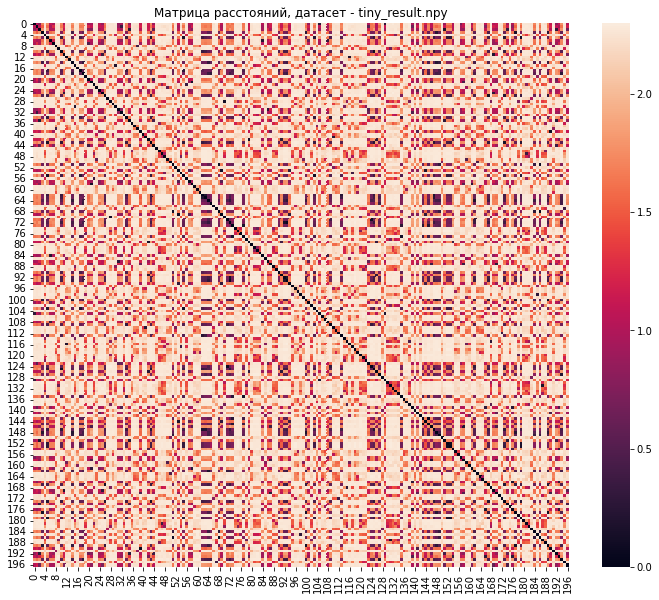

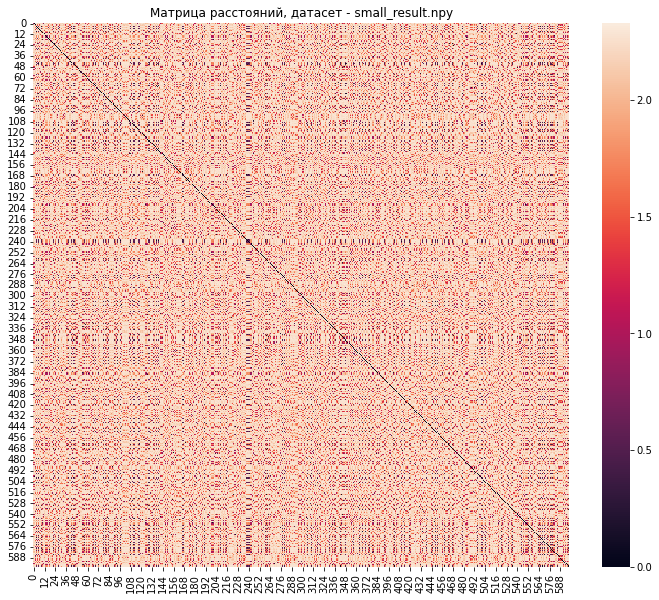

In [9]:
directory = '/content/drive/MyDrive/Python/procrustus_problem/'
file_name_1 = 'tiny_result.npy'
file_name_2 = 'small_result.npy'
dist_matrix_1 = np.load(directory + file_name_1, mmap_mode='r')
dist_matrix_2 = np.load(directory + file_name_2, mmap_mode='r')

plt.figure(figsize=(12, 10))
sns.heatmap(dist_matrix_1)
plt.title('Матрица расстояний, датасет - ' + file_name_1)
plt.show()

plt.figure(figsize=(12, 10))
sns.heatmap(dist_matrix_2)
plt.title('Матрица расстояний, датасет - ' + file_name_2)
plt.show()

In [14]:
directory = '/content/drive/MyDrive/Python/procrustus_problem/'
dataset_directory = '/content/drive/MyDrive/Python/procrustus_problem/data/'

for dataset_name, file_name in datasets:
    if file_name == 'xlarge_result':
        continue
    dist_matrix = np.load(directory + file_name + '.npy', mmap_mode='r')
    label_mask = show_clustering(dist_matrix, file_name)

    data = np.load(dataset_directory + dataset_name, mmap_mode='r')
    show_curves(data, label_mask, file_name)

Output hidden; open in https://colab.research.google.com to view.

Для самого большого датасета выведу результаты отдельно, так как у меня вылетает ошибка переполнения вывода, если выводить всё сразу

In [15]:
directory = '/content/drive/MyDrive/Python/procrustus_problem/'
dataset_directory = '/content/drive/MyDrive/Python/procrustus_problem/data/'
dataset_name = 'procrustus_problem_dataset_xlarge.npy'
file_name = 'xlarge_result'

dist_matrix = np.load(directory + file_name + '.npy', mmap_mode='r')
label_mask = show_clustering(dist_matrix, file_name)

data = np.load(dataset_directory + dataset_name, mmap_mode='r')
show_curves(data, label_mask, file_name)

Output hidden; open in https://colab.research.google.com to view.